In [1]:
#!pip install seaborn

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#import warnings
import warnings
warnings.filterwarnings('ignore')

## Eksplorasi Database

In [3]:
conn = sqlite3.connect("olist.db")

In [4]:
#Eksplorasi database olist
tableList = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tableList)

                                name
0       olist_order_customer_dataset
1                olist_order_dataset
2        olist_order_reviews_dataset
3       olist_order_payments_dataset
4          olist_order_items_dataset
5             olist_products_dataset
6              olist_sellers_dataset
7          olist_geolocation_dataset
8  product_category_name_translation


In [5]:
geolocation_query = 'SELECT * FROM olist_geolocation_dataset ogd ;'
df_geolocation = pd.read_sql(geolocation_query, conn)

In [7]:
customer_query = 'SELECT * FROM olist_order_customer_dataset oocd ;'
df_customer = pd.read_sql(customer_query, conn)

In [9]:
order_query = 'SELECT * FROM olist_order_dataset ood ;'
df_order = pd.read_sql(order_query,conn)

In [11]:
items_query = 'SELECT * FROM olist_order_items_dataset ooid ;'
df_items = pd.read_sql(items_query, conn)

In [13]:
payments_query = 'SELECT * FROM olist_order_payments_dataset oopd ;'
df_payments = pd.read_sql(payments_query, conn)

In [15]:
review_query = 'SELECT * FROM olist_order_reviews_dataset oord ;'
df_review = pd.read_sql(review_query, conn)

In [17]:
products_query = 'SELECT * FROM olist_products_dataset opd ;'
pd_products = pd.read_sql(products_query, conn)

In [19]:
sellers_query = 'SELECT * FROM olist_sellers_dataset osd ;'
df_sellers = pd.read_sql(sellers_query, conn)

In [21]:
translationCat_query = 'SELECT * FROM product_category_name_translation'
df_translationCat = pd.read_sql(translationCat_query, conn)

## Top 10 Kategori Produk Paling Laku

### Akses Database

In [47]:
top10_query = """
SELECT *
FROM 
    olist_order_items_dataset ooid
join 
    olist_products_dataset opd using(product_id)
join
    product_category_name_translation using(product_category_name)
"""

df_top10 = pd.read_sql(top10_query, conn)

### EDA

In [48]:
df_top10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111023 entries, 0 to 111022
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index                          111023 non-null  int64  
 1   order_id                       111023 non-null  object 
 2   order_item_id                  111023 non-null  int64  
 3   product_id                     111023 non-null  object 
 4   seller_id                      111023 non-null  object 
 5   shipping_limit_date            111023 non-null  object 
 6   price                          111023 non-null  float64
 7   freight_value                  111023 non-null  float64
 8   index                          111023 non-null  int64  
 9   product_category_name          111023 non-null  object 
 10  product_name_lenght            111023 non-null  float64
 11  product_description_lenght     111023 non-null  float64
 12  product_photos_qty            

In [49]:
# Mencari nilai null
df_top10.isna().sum()

index                            0
order_id                         0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
index                            0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 1
product_length_cm                1
product_height_cm                1
product_width_cm                 1
index                            0
product_category_name_english    0
dtype: int64

In [50]:
# Mencari Duplicate Data
df_top10.duplicated().sum()

0

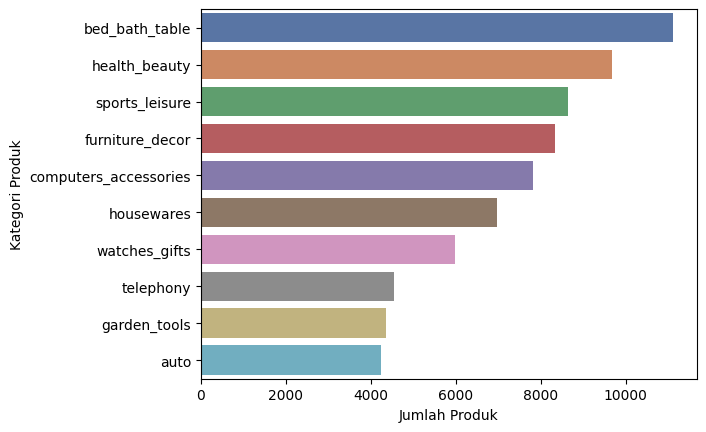

In [51]:
# Menghitung jumlah produk dalam masing-masing kategori
category_counts = df_top10['product_category_name_english'].value_counts()

# Mengurutkan kategori produk berdasarkan jumlah produk
sorted_categories = category_counts.sort_values(ascending=False)

# Mengambil 10 kategori produk teratas
top_10_categories = sorted_categories.head(10)

# Membuat grafik barplot
sns.barplot(y=top_10_categories.index, x=top_10_categories.values, palette="deep")

# Atur label sumbu y
plt.ylabel("Kategori Produk")

# Atur label sumbu x
plt.xlabel("Jumlah Produk")

# Menampilkan grafik
plt.show()

### Analisis dan Perbandingan dengan Rata-Rata Harga Produk

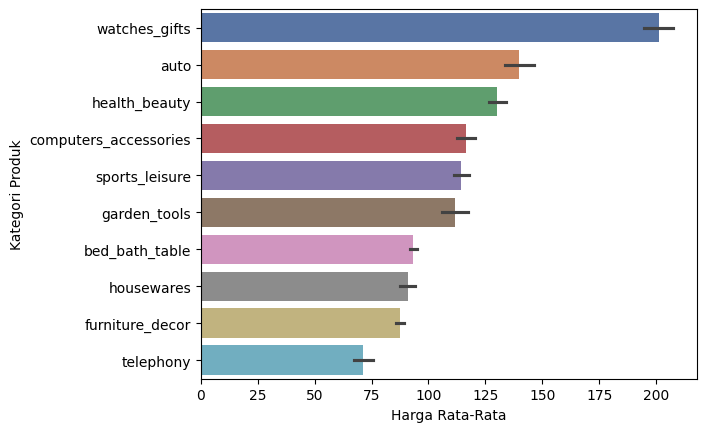

In [31]:
# Mengambil data untuk 10 kategori produk teratas
df_top10 = df_top10[df_top10['product_category_name_english'].isin(top_10_categories.index)]

# harga rata2
avg_price = df_top10.groupby("product_category_name_english")["price"].mean()

# Membuat grafik barplot dengan harga rata-rata per kategori produk
sns.barplot(y="product_category_name_english", x="price", data=df_top10, estimator=np.mean, palette="deep", order=avg_price.sort_values(ascending=False).index)

# Atur label sumbu x
plt.ylabel("Kategori Produk")

# Atur label sumbu y
plt.xlabel("Harga Rata-Rata")

# Menampilkan grafik
plt.show()


In [32]:
# Menggabungkan kedua Series di atas ke dalam satu DataFrame
data = pd.DataFrame({'jumlah_penjualan': category_counts, 'harga_rata_rata': avg_price})

# Menghitung korelasi antara jumlah penjualan dan harga rata-rata
correlation = data['jumlah_penjualan'].corr(data['harga_rata_rata'])

print(f"Korelasi antara jumlah penjualan dan harga rata-rata: {correlation}")

Korelasi antara jumlah penjualan dan harga rata-rata: -0.16019468381165974


### Explanation
Dapat dilihat ternyata harga tidak terlalu berpengaruh pada tingkat penjualan produknya, kategori health_beauty yang merupakan kategori dengan harga relatif mahal (top 3 harga rata-rata termahal) ternyata merupakan kategori produk dengan jumlah penjualan terbesar kedua.

## 3 Kota dengan Penjualan Terbesar & 3 Kota dengan Penjualan Terkecil

### Akses Database

In [5]:
top3_query = """
SELECT *
FROM 
    olist_order_dataset ood
join 
    olist_order_customer_dataset oocd using(customer_id)
join
    olist_order_payments_dataset oopd using(order_id)

"""
df_top3 = pd.read_sql(top3_query, conn)

## EDA

In [7]:
# Mengambil kolom2 yang diperlukan
df_top3 = df_top3[['customer_city','payment_value', 'customer_zip_code_prefix']]

In [9]:
df_top3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_city             103886 non-null  object 
 1   payment_value             103886 non-null  float64
 2   customer_zip_code_prefix  103886 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.4+ MB


In [27]:
# Eksplorasi nama-nama kota
df_top3['customer_city'].unique()

array(['sao paulo', 'barreiras', 'vianopolis', ..., 'messias targino',
       'campo do tenente', 'nova vicosa'], dtype=object)

In [28]:
#Melihat jumlah kota
df_top3['customer_city'].nunique()

3955

In [11]:
#Eksplorasi Sebaran Data
df_top3.describe()

,payment_value,customer_zip_code_prefix
count,103886.000000,103886.000000
mean,154.100380,35072.550555
std,217.494064,29743.491677
min,0.000000,1003.000000
25%,56.790000,11366.250000
50%,100.000000,24360.000000
75%,171.837500,58418.000000
max,13664.080000,99990.000000


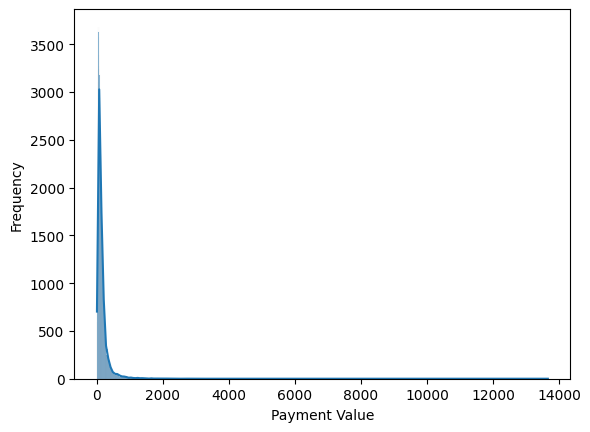

In [13]:
# Menggambarkan histogram dari kolom "payment_value"
sns.histplot(df_top3['payment_value'], kde=True)  # KDE (Kernel Density Estimate) untuk melihat distribusi

# Atur label sumbu x
plt.xlabel("Payment Value")

# Atur label sumbu y
plt.ylabel("Frequency")

# Menampilkan grafik
plt.show()

In [18]:
# Fungsi untuk menghapus outlier menggunakan metode IQR pada kolom payment value
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lowerBound) & (df[column] <= upperBound)]
    return df_filtered

df_top3 = remove_outliers_iqr(df_top3, 'payment_value')

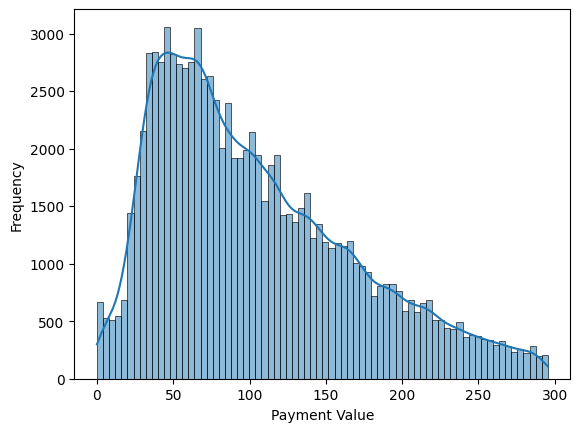

In [19]:
# Menggambarkan histogram dari kolom "payment_value" yang sudah dibuang outliernya
sns.histplot(df_top3['payment_value'], kde=True) 

# Atur label sumbu x
plt.xlabel("Payment Value")

# Atur label sumbu y
plt.ylabel("Frequency")

# Menampilkan grafik
plt.show()

In [24]:
# Menghitung total penjualan (payment_value) per kota pelanggan
citySales = df_top3.groupby('customer_city')['payment_value'].sum().sort_values(ascending=False)

# Mengambil 3 kota dengan total penjualan tertinggi
top_3cities = citySales.head(3)

# Mengambil 3 kota dengan total penjualan terendah
bot_3cities = citySales.tail(3)

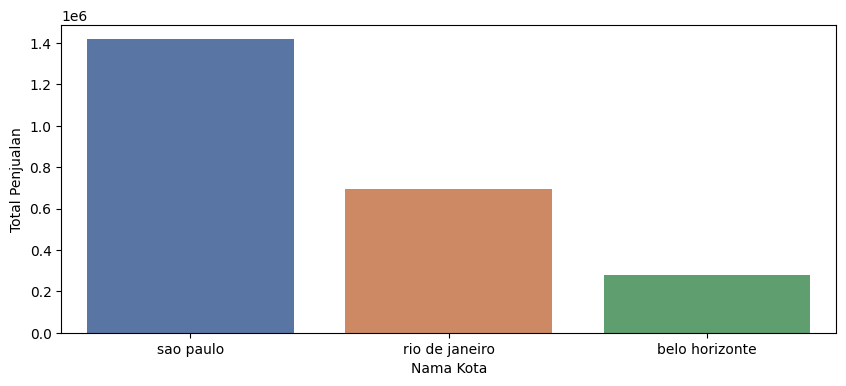

In [43]:
# Visualisasi Data
plt.figure(figsize=(10, 4))

sns.barplot(x=x1, y=y1, palette="deep")
# Atur label sumbu y
plt.ylabel("Total Penjualan")

# Atur label sumbu x
plt.xlabel("Nama Kota")

# Menampilkan grafik
plt.show()


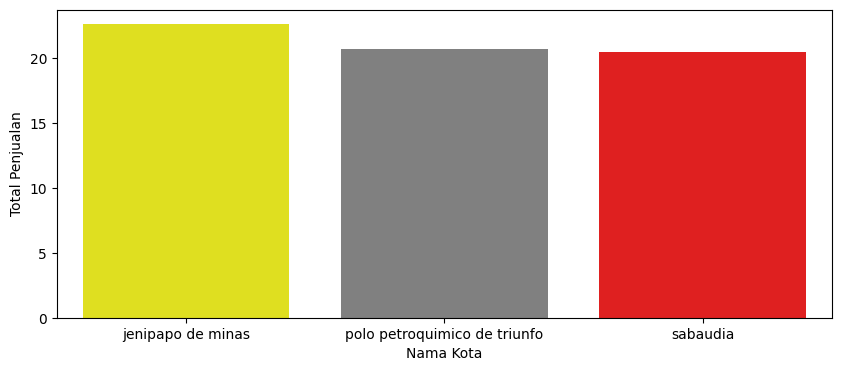

In [52]:
# Visualisasi Data
plt.figure(figsize=(10, 4))

custom_colors = ["yellow", "grey", "red"]
sns.barplot(x=x1, y=y1, palette= custom_colors)

# Atur label sumbu y
plt.ylabel("Total Penjualan")

# Atur label sumbu x
plt.xlabel("Nama Kota")

# Menampilkan grafik
plt.show()

### Analisis Korelasi Banyaknya trasnsaksi dengan total nominal transaksi

In [60]:
df_top3['customer_city'].value_counts().sort_values(ascending=False)

customer_city
sao paulo                 14878
rio de janeiro             6442
belo horizonte             2620
brasilia                   1973
curitiba                   1405
                          ...  
agua preta                    1
traipu                        1
quilometro 14 do mutum        1
vale do sol                   1
nova vicosa                   1
Name: count, Length: 3955, dtype: int64

In [82]:

citySales = df_top3.groupby('customer_city')['payment_value'].sum()
sell_counts = df_top3['customer_city'].value_counts()

# Menggabungkan kedua Series di atas ke dalam satu DataFrame
data2 = pd.DataFrame({'jumlah penjualan': sell_counts, 'total penjualan': citySales})

# Menghitung korelasi antara jumlah penjualan dan harga rata-rata
correlation2 = data2['jumlah penjualan'].corr(data2['total penjualan'])
print(f"Korelasi antara jumlah total nominal transaksi dan Jumlah total transaksi pada setiap kota: {correlation2}")

Korelasi antara jumlah total nominal transaksi dan Jumlah total transaksi pada setiap kota: 0.998585751059122


### Explanation
Jumlah transaksi berbanding lurus dengan jumlah total nominal transaksi yang berlangsung pada suatu daerah. Semakin banyak transaski maka total nominalnya juga semain besar, hal ini berarti peran kuantitas produk atau banyaknya jumlah produk yang dibeli memiliki pengaruh terhadap total pendapatan perusahaan pada setiap kota. Kedepannya lebih baik jika memperbanyak produk dengan harga yang relatif terjangkau daripada menjual produk luxury dengan harga mahal untuk 1 produk.

## Tingkat Kepuasan Per Produk

### Akses Database

In [9]:
Rat_Q = """
SELECT *
FROM 
    olist_order_reviews_dataset oord
join 
    olist_order_dataset ood using(order_id)
join
    olist_order_items_dataset ooid using(order_id)
join 
    olist_products_dataset using(product_id)
join 
    product_category_name_translation using(product_category_name)

"""
df_rating = pd.read_sql(Rat_Q, conn)

### EDA

In [10]:
df_rating

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,customer_id,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,index,product_category_name_english
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59,1871,41dcb106f807e993532d446263290104,...,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,5,sports_leisure
1,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59,1871,41dcb106f807e993532d446263290104,...,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,5,sports_leisure
2,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13,90488,8a2e7ef9053dea531e4dc76bd6d853e6,...,informatica_acessorios,47.0,493.0,1.0,245.0,19.0,14.0,14.0,1,computers_accessories
3,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24,78882,e226dfed6544df5b7b87a48208690feb,...,informatica_acessorios,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,1,computers_accessories
4,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,27557,de6dff97e5f1ba84a3cd9a3bc97df5f6,...,ferramentas_jardim,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,16,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110745,99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,None,None,2018-07-07 00:00:00,2018-07-14 17:18:30,66506,d8c466a3e7c4cda36cd4ae7d577f44f4,...,moveis_decoracao,56.0,623.0,1.0,7250.0,100.0,25.0,25.0,4,furniture_decor
110746,99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,None,None,2017-12-09 00:00:00,2017-12-11 20:06:42,84918,d0d7086dea6fcf42b9b690b9f3745c58,...,brinquedos,51.0,465.0,1.0,2363.0,23.0,27.0,19.0,14,toys
110747,99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,None,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,9817,fcc7b1caafe3b77fd587bab964c4d1fb,...,papelaria,45.0,283.0,3.0,4100.0,40.0,37.0,29.0,12,stationery
110748,99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,None,None,2018-07-01 00:00:00,2018-07-02 12:59:13,29006,3aa00401736823c73e9fe8683328fa6b,...,esporte_lazer,58.0,998.0,5.0,600.0,16.0,10.0,11.0,5,sports_leisure


In [11]:
df_rating = df_rating[['review_score','product_category_name_english']]

In [13]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110750 entries, 0 to 110749
Data columns (total 2 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   review_score                   110750 non-null  int64 
 1   product_category_name_english  110750 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [15]:
df_rating['review_score'].nunique()

5

In [16]:
df_rating['review_score'].unique()

array([4, 5, 1, 3, 2], dtype=int64)

In [17]:
# Mencari nilai null
df_rating.isna().sum()

review_score                     0
product_category_name_english    0
dtype: int64

In [23]:
poductRating = df_rating.groupby('product_category_name_english')['review_score'].mean()

In [30]:
poductRating.sort_values(ascending=False)

product_category_name_english
cds_dvds_musicals            4.642857
fashion_childrens_clothes    4.500000
books_general_interest       4.446266
costruction_tools_tools      4.444444
flowers                      4.419355
                               ...   
fashion_male_clothing        3.641221
home_comfort_2               3.629630
office_furniture             3.493183
diapers_and_hygiene          3.256410
security_and_services        2.500000
Name: review_score, Length: 71, dtype: float64

In [74]:
topRating = poductRating.sort_values(ascending=False).head(10)

In [75]:
topRating

product_category_name_english
cds_dvds_musicals                        4.642857
fashion_childrens_clothes                4.500000
books_general_interest                   4.446266
costruction_tools_tools                  4.444444
flowers                                  4.419355
books_imported                           4.400000
books_technical                          4.368421
food_drink                               4.315412
luggage_accessories                      4.315257
small_appliances_home_oven_and_coffee    4.302632
Name: review_score, dtype: float64

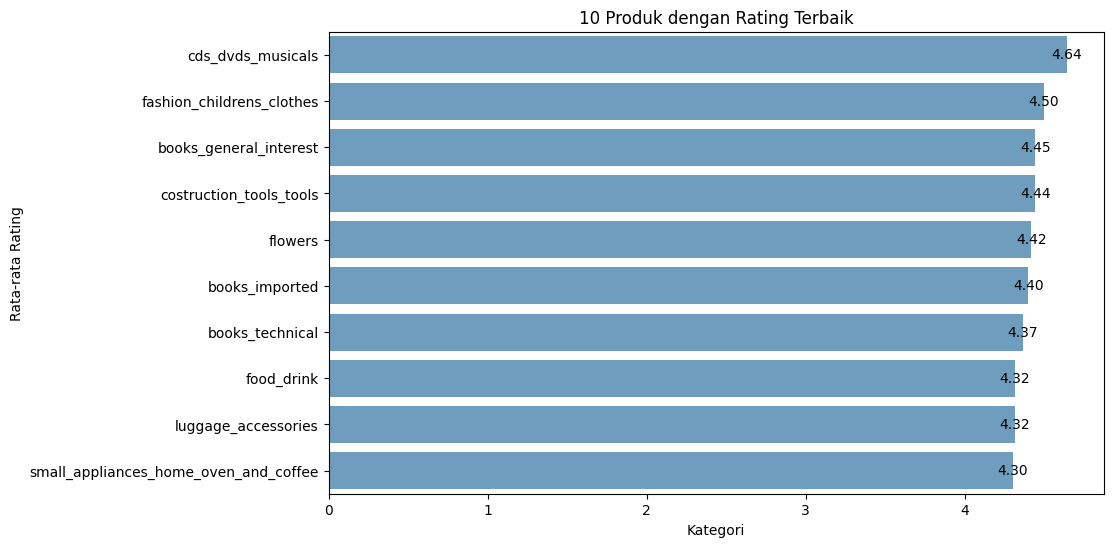

In [114]:
# Membuat bar chart dengan seaborn
plt.figure(figsize=(10, 6))  # Mengatur ukuran diagram
ax = sns.barplot(x=topRating.values, y=topRating.index, alpha=0.7)


# Menambahkan label sumbu dan judul
plt.xlabel('Kategori')
plt.ylabel('Rata-rata Rating')
plt.title('10 Produk dengan Rating Terbaik')

# Menampilkan nilai pada setiap batang
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2), ha='center', va='center', fontsize=10, color='black')

# Menampilkan diagram batang
plt.show()

### Analisis Rating Produk

In [104]:
topRating.describe()

count    10.000000
mean      4.415464
std       0.103222
min       4.302632
25%       4.328664
50%       4.409677
75%       4.445811
max       4.642857
Name: review_score, dtype: float64

In [95]:
# Ambil rating dari top 10 produkter laku
top10_prod = ['sports_leisure', 'bed_bath_table', 'health_beauty', 'furniture_decor', 'computers_accessories','housewares', 'watches_gifts', 'telephony', 'garden_tools','auto']
top10_rat = poductRating.loc[top10_prod].sort_values(ascending=False)

In [97]:
top10_rat.describe()

count    10.000000
mean      4.011002
std       0.087021
min       3.895663
25%       3.934831
50%       4.030947
75%       4.062888
max       4.142768
Name: review_score, dtype: float64

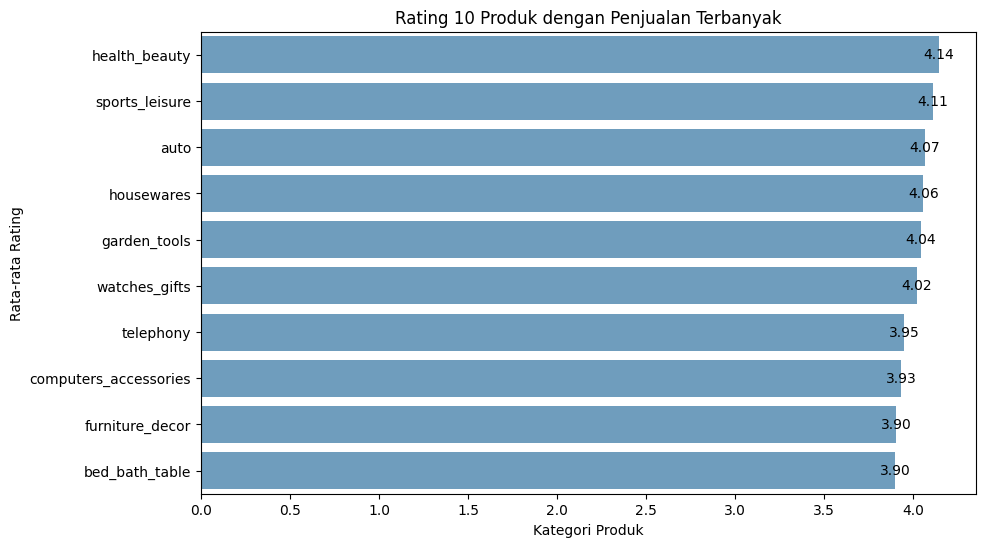

In [113]:
# Membuat bar chart dengan seaborn
plt.figure(figsize=(10, 6))  # Mengatur ukuran diagram
ax = sns.barplot(x=top10_rat.values, y=top10_rat.index, alpha=0.7)


# Menambahkan label sumbu dan judul
plt.xlabel('Kategori Produk')
plt.ylabel('Rata-rata Rating')
plt.title('Rating 10 Produk dengan Penjualan Terbanyak')

# Menampilkan nilai pada setiap batang
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2), ha='center', va='center', fontsize=10, color='black')

# Menampilkan diagram batang
plt.show()

### Explanation

Ternyata produk dengan rating tinggi bukan produk yang paling banyak terjual (top 10), ini berarti produk-produk yang memiliki rating tinggi berpotensi untuk menjadi produk yang bisa saja memiliki jumlah penjualan yang tinggi, karena rating yang tinggi berarti tingkat kepuasan terhadap produk tersebut juga tinggi. Kepuasan yang tinggi sudah menjadi modal tersendiri pada produk-produk tersebut, sehingga kedepannya diperlukan penambahan atau peningkatan penjualan produk-produk yang memiliki nilai rating yang tinggi